In [1]:
import json


# 读取数据
with open("../xfdata/dataset/job_list.json", "r", encoding="utf-8") as f:
    job_list = json.load(f)
with open("../xfdata/dataset/train.json", "r", encoding="utf-8") as f:
    train = json.load(f)
with open("../xfdata/dataset/test.json", "r", encoding="utf-8") as f:
    test = json.load(f)
    
# 1、教育经历
with open("../user_data/profileEduExps_sentences.json", "r", encoding="utf-8") as f:
    profileEduExps_sentences = json.load(f)

# 2、社会经历
with open("../user_data/profileSocialExps_sentences.json", "r", encoding="utf-8") as f:
    profileSocialExps_sentences = json.load(f)

# 3、项目经历
with open("../user_data/profileProjectExps_sentences.json", "r", encoding="utf-8") as f:
    profileProjectExps_sentences = json.load(f)

# 4、工作经历
with open("../user_data/profileWorkExps_sentences.json", "r", encoding="utf-8") as f:
    profileWorkExps_sentences = json.load(f)

# 5、技能
with open("../user_data/profileSkills_sentences.json", "r", encoding="utf-8") as f:
    profileSkills_sentences = json.load(f)

# 6、荣誉
with open("../user_data/profileAwards_sentences.json", "r", encoding="utf-8") as f:
    profileAwards_sentences = json.load(f)

# 7、求职意愿
with open("../user_data/profileDesire_sentences.json", "r", encoding="utf-8") as f:
    profileDesire_sentences = json.load(f)

# 8、语言
with open("../user_data/profileLanguage_sentences.json", "r", encoding="utf-8") as f:
    profileLanguage_sentences = json.load(f)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# 获取标签
labels = [i["positionID"] for i in train]
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(labels)
print(len(np.unique(labels)))

51


In [3]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig

path = "../user_data/output/checkpoint-11181"
config = BertConfig.from_pretrained(path)
config.num_labels = 51
model = BertForSequenceClassification.from_pretrained(path, config=config)
tokenizer = BertTokenizer.from_pretrained(path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../user_data/output/checkpoint-11181 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


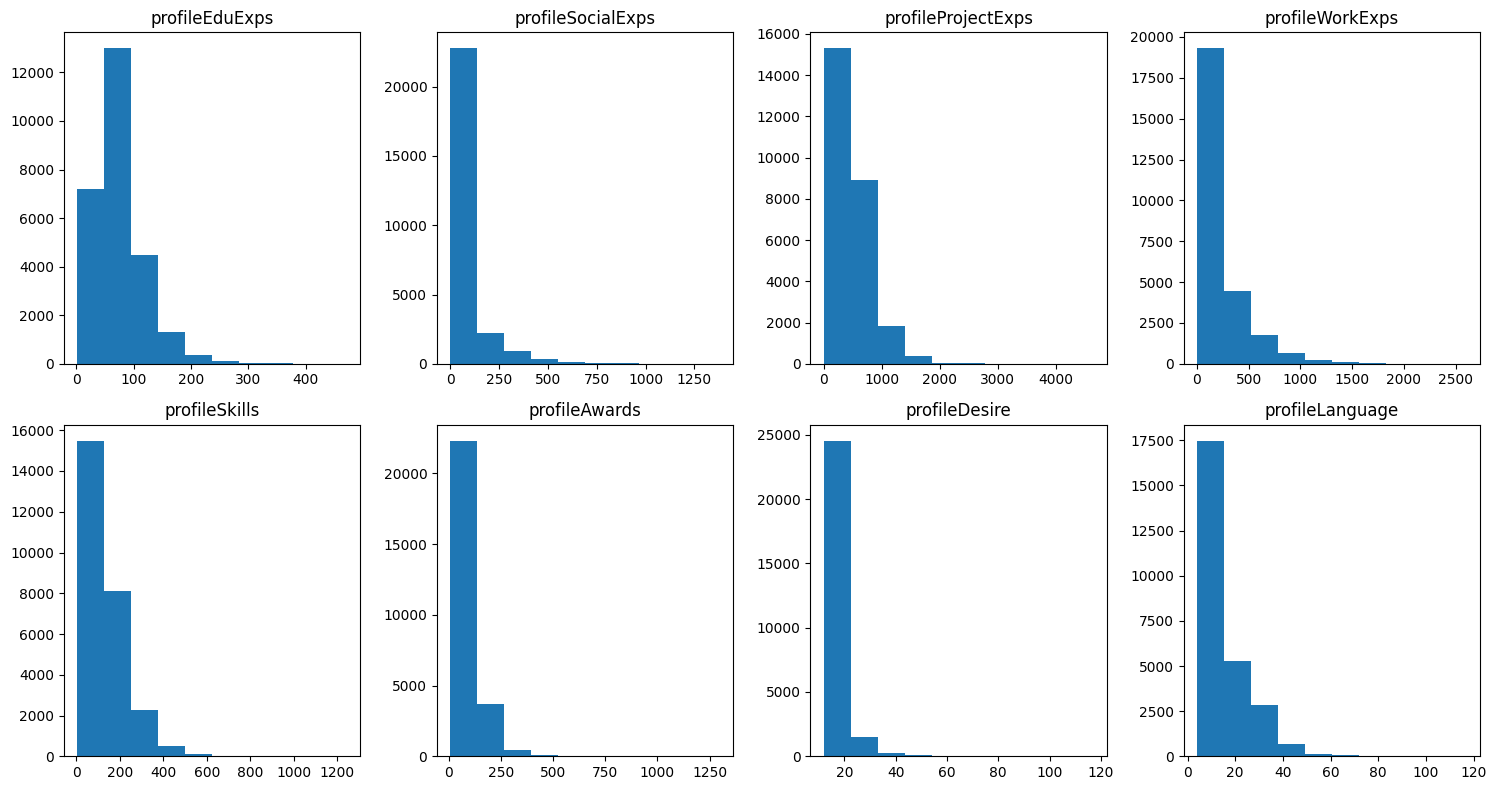

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 8))
plt.subplot(2, 4, 1)
plt.hist([len(i) for i in profileEduExps_sentences])
plt.title("profileEduExps")
plt.subplot(2, 4, 2)
plt.hist([len(i) for i in profileSocialExps_sentences])
plt.title("profileSocialExps")
plt.subplot(2, 4, 3)
plt.hist([len(i) for i in profileProjectExps_sentences])
plt.title("profileProjectExps")
plt.subplot(2, 4, 4)
plt.hist([len(i) for i in profileWorkExps_sentences])
plt.title("profileWorkExps")
plt.subplot(2, 4, 5)
plt.hist([len(i) for i in profileSkills_sentences])
plt.title("profileSkills")
plt.subplot(2, 4, 6)
plt.hist([len(i) for i in profileAwards_sentences])
plt.title("profileAwards")
plt.subplot(2, 4, 7)
plt.hist([len(i) for i in profileDesire_sentences])
plt.title("profileDesire")
plt.subplot(2, 4, 8)
plt.hist([len(i) for i in profileLanguage_sentences])
plt.title("profileLanguage")
plt.tight_layout()
plt.show()

# 仅使用profileSocialExps

In [6]:
sentences = profileProjectExps_sentences

train_sentences, test_sentences = sentences[: len(train)], sentences[len(train): ]
print(len(train_sentences), len(test_sentences))
train_idx = np.load("../user_data/train_idx.npy")
valid_idx = np.load("../user_data/valid_idx.npy")
train_sentences, valid_sentences = [train_sentences[idx] for idx in train_idx], [train_sentences[idx] for idx in valid_idx]
train_labels, valid_labels = [labels[idx] for idx in train_idx], [labels[idx] for idx in valid_idx]
print(len(train_sentences), len(train_labels))
print(len(valid_sentences), len(valid_labels))

20000 6500
16000 16000
4000 4000


In [8]:
from datasets import Dataset


train_dataset = Dataset.from_dict({
    "text": train_sentences,
    "label": train_labels
})
valid_dataset = Dataset.from_dict({
    "text": valid_sentences,
    "label": valid_labels
})
test_dataset = Dataset.from_dict({
    "text": test_sentences
})

In [9]:
def preprocess(examples):
    """单个处理"""
    input_ids, token_type_ids, attention_mask = tokenizer.encode_plus(
        examples["text"],
        padding="max_length",
        max_length=512,
        truncation=True,
        return_tensors="pt"
    ).values()
    examples["input_ids"] = input_ids[0]
    examples["token_type_ids"] = token_type_ids[0]
    examples["attention_mask"] = attention_mask[0]
    return examples


train_encoded = train_dataset.map(preprocess)
valid_encoded = valid_dataset.map(preprocess)
test_encoded = test_dataset.map(preprocess)

train_encoded.set_format("torch", columns=["label", "input_ids", "token_type_ids", "attention_mask"])
valid_encoded.set_format("torch", columns=["label", "input_ids", "token_type_ids", "attention_mask"])
test_encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask"])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

In [10]:
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
    output_dir="../user_data/profileSocialExps_classification_output",  # 输出目录
    overwrite_output_dir=True,                         # 是否覆盖输出目录
    num_train_epochs=6,                               # 训练轮数
    per_device_train_batch_size=64,                    # 每个设备的批次大小
    per_device_eval_batch_size=8,                     # 每个设备的评估批次大小
    warmup_steps=500,                                 # 预热步数
    weight_decay=0.01,                                # 权重衰减
    logging_dir='../user_data/profileSocialExps_classification_logs',   # 日志保存路径
    logging_steps=10,                                 # 每 10 步记录一次日志
    eval_strategy="epoch",                            # 每个 epoch 进行评估
    save_strategy="epoch",                            # 每个 epoch 保存模型
    load_best_model_at_end=True,                      # 在训练结束时加载最佳模型
    greater_is_better=False,                           # 指标越高越好
    save_total_limit=3,                               # 最多保留3个模型
)

2024-09-14 19:46:25.906900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 19:46:25.922906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 19:46:25.927837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 19:46:25.944161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 19:46:26.585916: W tensorflow/compiler/tf2

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded,
    eval_dataset=valid_encoded,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.580100,2.604475
2,2.432700,2.382029
3,2.236300,2.265842
4,2.215900,2.194776
5,1.924000,2.205204
6,1.858500,2.210276


TrainOutput(global_step=1500, training_loss=2.2923766377766928, metrics={'train_runtime': 525.0638, 'train_samples_per_second': 182.835, 'train_steps_per_second': 2.857, 'total_flos': 1.2727982850048e+16, 'train_loss': 2.2923766377766928, 'epoch': 6.0})

In [12]:
# 训练完成后，获取最佳模型的路径
best_model_path = trainer.state.best_model_checkpoint
print(f"Best model checkpoint path: {best_model_path}")

Best model checkpoint path: ../user_data/profileSocialExps_classification_output/checkpoint-1000


In [13]:
from sklearn.metrics import f1_score


result = trainer.predict(train_encoded)
print(f1_score(result.label_ids, result.predictions.argmax(axis=1), average="macro"))
result = trainer.predict(valid_encoded)
print(f1_score(result.label_ids, result.predictions.argmax(axis=1), average="macro"))
result = trainer.predict(test_encoded)
y_pred = result.predictions
np.save("../user_data/pred_matrix/profileSocialExps.npy", y_pred)

0.1462342196531493


0.11528333284336449
